In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
from xgboost import XGBRFRegressor, XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_squared_error


In [3]:
df = pd.read_json('json_archive/model_5_df.json')
df['Date/Time (PST)'] = pd.to_datetime(df['Date/Time (PST)'])

In [4]:
df.head()

,Date/Time (PST),Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),date,24 Hour Snow (in),Total Snow Depth (in),...,month,max_1_day_temp,min_1_day_temp,max_2_day_temp,min_2_day_temp,max_1_day_wind,max_2_day_wind,max_1_day_snow,max_2_day_snow,max_3_day_snow
0,2015-12-04 00:00:00,12.76,30.29,0.022,3.943,21.500,259.8,2015-12-04,2.499,25.66,...,12,30.29,20.94,32.02,13.81,21.50,21.50,46.490,46.49,46.49
1,2015-12-04 01:00:00,13.51,29.98,0.000,3.109,10.390,278.7,2015-12-04,2.701,23.25,...,12,30.29,21.20,32.02,15.03,21.50,21.50,46.490,46.49,46.49
10,2015-12-04 10:00:00,12.74,29.41,0.000,2.261,7.299,261.7,2015-12-04,1.083,26.44,...,12,30.29,23.39,30.29,17.25,21.50,21.50,2.701,46.49,46.49
100,2015-12-06 04:00:00,12.81,25.22,1.162,2.183,3.178,94.4,2015-12-06,0.401,35.68,...,12,25.22,23.93,25.22,23.93,7.19,7.19,10.610,10.61,10.61
1000,2016-01-05 16:00:00,12.77,24.26,1.447,2.001,2.740,85.4,2016-01-05,0.664,76.38,...,1,25.84,18.47,25.84,14.10,9.89,10.43,4.284,46.49,46.49


In [5]:
df['year'], df['month'],df['day'] = (df["Date/Time (PST)"].dt.year,
df["Date/Time (PST)"].dt.month,df["Date/Time (PST)"].dt.day)
    
    

In [6]:
df.head()

,Date/Time (PST),Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),date,24 Hour Snow (in),Total Snow Depth (in),...,min_1_day_temp,max_2_day_temp,min_2_day_temp,max_1_day_wind,max_2_day_wind,max_1_day_snow,max_2_day_snow,max_3_day_snow,year,day
0,2015-12-04 00:00:00,12.76,30.29,0.022,3.943,21.500,259.8,2015-12-04,2.499,25.66,...,20.94,32.02,13.81,21.50,21.50,46.490,46.49,46.49,2015,4
1,2015-12-04 01:00:00,13.51,29.98,0.000,3.109,10.390,278.7,2015-12-04,2.701,23.25,...,21.20,32.02,15.03,21.50,21.50,46.490,46.49,46.49,2015,4
10,2015-12-04 10:00:00,12.74,29.41,0.000,2.261,7.299,261.7,2015-12-04,1.083,26.44,...,23.39,30.29,17.25,21.50,21.50,2.701,46.49,46.49,2015,4
100,2015-12-06 04:00:00,12.81,25.22,1.162,2.183,3.178,94.4,2015-12-06,0.401,35.68,...,23.93,25.22,23.93,7.19,7.19,10.610,10.61,10.61,2015,6
1000,2016-01-05 16:00:00,12.77,24.26,1.447,2.001,2.740,85.4,2016-01-05,0.664,76.38,...,18.47,25.84,14.10,9.89,10.43,4.284,46.49,46.49,2016,5


In [7]:
df = df.sort_values(by='Date/Time (PST)',ascending=True)

In [8]:
df.head()

,Date/Time (PST),Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),date,24 Hour Snow (in),Total Snow Depth (in),...,min_1_day_temp,max_2_day_temp,min_2_day_temp,max_1_day_wind,max_2_day_wind,max_1_day_snow,max_2_day_snow,max_3_day_snow,year,day
0,2015-12-04 00:00:00,12.76,30.29,0.022,3.943,21.50,259.8,2015-12-04,2.499,25.66,...,20.94,32.02,13.81,21.5,21.5,46.49,46.49,46.49,2015,4
1,2015-12-04 01:00:00,13.51,29.98,0.000,3.109,10.39,278.7,2015-12-04,2.701,23.25,...,21.20,32.02,15.03,21.5,21.5,46.49,46.49,46.49,2015,4
2,2015-12-04 02:00:00,12.81,29.98,0.000,2.432,8.70,266.3,2015-12-04,2.295,23.77,...,21.33,32.02,16.86,21.5,21.5,46.49,46.49,46.49,2015,4
3,2015-12-04 03:00:00,12.79,30.01,0.000,3.243,14.31,279.1,2015-12-04,2.566,25.66,...,21.33,32.02,17.25,21.5,21.5,46.49,46.49,46.49,2015,4
4,2015-12-04 04:00:00,12.78,29.08,0.000,6.408,19.64,285.1,2015-12-04,1.756,25.71,...,21.54,32.02,17.25,21.5,21.5,46.43,46.49,46.49,2015,4


In [51]:
ddf = df.copy()
ddf['id'] = ddf.index
ddf.index = ddf['Date/Time (PST)']
ddf = ddf.drop('Date/Time (PST)', axis=1)

In [52]:
ddf.head()

,Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),date,24 Hour Snow (in),Total Snow Depth (in),area,...,max_2_day_temp,min_2_day_temp,max_1_day_wind,max_2_day_wind,max_1_day_snow,max_2_day_snow,max_3_day_snow,year,day,id
Date/Time (PST),,,,,,,,,,,,,,,,,,,,,
2015-12-04 00:00:00,12.76,30.29,0.022,3.943,21.50,259.8,2015-12-04,2.499,25.66,Stevens Pass,...,32.02,13.81,21.5,21.5,46.49,46.49,46.49,2015,4,0
2015-12-04 01:00:00,13.51,29.98,0.000,3.109,10.39,278.7,2015-12-04,2.701,23.25,Stevens Pass,...,32.02,15.03,21.5,21.5,46.49,46.49,46.49,2015,4,1
2015-12-04 02:00:00,12.81,29.98,0.000,2.432,8.70,266.3,2015-12-04,2.295,23.77,Stevens Pass,...,32.02,16.86,21.5,21.5,46.49,46.49,46.49,2015,4,2
2015-12-04 03:00:00,12.79,30.01,0.000,3.243,14.31,279.1,2015-12-04,2.566,25.66,Stevens Pass,...,32.02,17.25,21.5,21.5,46.49,46.49,46.49,2015,4,3
2015-12-04 04:00:00,12.78,29.08,0.000,6.408,19.64,285.1,2015-12-04,1.756,25.71,Stevens Pass,...,32.02,17.25,21.5,21.5,46.43,46.49,46.49,2015,4,4


In [56]:
def get_previous_day_snow(df, dt):
    target_hour = dt - pd.Timedelta('1 day')
    if target_hour in df.index:
        return df.loc[target_hour, '24 Hour Snow (in)']
    else:
        return None

In [57]:
ddf['Prev Day 24 Hour Snow (in)'] = [get_previous_day_snow(ddf, dt) for dt in ddf.index]

In [59]:
ddf.head(25)

,Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),date,24 Hour Snow (in),Total Snow Depth (in),area,...,min_2_day_temp,max_1_day_wind,max_2_day_wind,max_1_day_snow,max_2_day_snow,max_3_day_snow,year,day,id,Prev Day 24 Hour Snow (in)
Date/Time (PST),,,,,,,,,,,,,,,,,,,,,
2015-12-04 00:00:00,12.76,30.29,0.022,3.943,21.500,259.8,2015-12-04,2.499,25.66,Stevens Pass,...,13.81,21.50,21.50,46.490,46.49,46.49,2015,4,0,None
2015-12-04 01:00:00,13.51,29.98,0.000,3.109,10.390,278.7,2015-12-04,2.701,23.25,Stevens Pass,...,15.03,21.50,21.50,46.490,46.49,46.49,2015,4,1,None
2015-12-04 02:00:00,12.81,29.98,0.000,2.432,8.700,266.3,2015-12-04,2.295,23.77,Stevens Pass,...,16.86,21.50,21.50,46.490,46.49,46.49,2015,4,2,None
2015-12-04 03:00:00,12.79,30.01,0.000,3.243,14.310,279.1,2015-12-04,2.566,25.66,Stevens Pass,...,17.25,21.50,21.50,46.490,46.49,46.49,2015,4,3,None
2015-12-04 04:00:00,12.78,29.08,0.000,6.408,19.640,285.1,2015-12-04,1.756,25.71,Stevens Pass,...,17.25,21.50,21.50,46.430,46.49,46.49,2015,4,4,None
2015-12-04 05:00:00,12.77,28.80,0.000,3.326,10.540,278.3,2015-12-04,0.275,21.87,Stevens Pass,...,17.25,21.50,21.50,4.420,46.49,46.49,2015,4,5,None
2015-12-04 06:00:00,12.76,29.04,0.000,2.063,6.861,259.4,2015-12-04,0.141,24.02,Stevens Pass,...,17.25,21.50,21.50,4.420,46.49,46.49,2015,4,6,None
2015-12-04 07:00:00,12.75,28.97,0.000,1.975,5.918,251.7,2015-12-04,0.409,23.88,Stevens Pass,...,17.25,21.50,21.50,3.411,46.49,46.49,2015,4,7,None
2015-12-04 08:00:00,12.75,28.29,0.000,2.412,6.576,250.6,2015-12-04,0.947,25.50,Stevens Pass,...,17.25,21.50,21.50,2.701,46.49,46.49,2015,4,8,None


In [9]:
X = df[['Battery Voltage (v)', 'Temperature (deg F)',
            'Wind Speed Minimum (mph)', 'Wind Speed Average (mph)',
            'Wind Speed Maximum (mph)', 'Wind Direction (deg.)',
            '24 Hour Snow (in)', 'Total Snow Depth (in)','max_1_day_temp',
            'min_1_day_temp', 'max_2_day_temp', 'min_2_day_temp',
            'max_1_day_snow', 'max_2_day_snow', 'max_3_day_snow','year','month','day']]

y = df['danger_near_treeline']

X_train, X_test, y_train, y_test = X[:12578], X[12578:], y[:12578], y[12578:]

In [10]:
ss = StandardScaler()

lr = LinearRegression()
rfr = RandomForestRegressor(n_estimators=100)
gbr = GradientBoostingRegressor(n_estimators=100)
knnr = KNeighborsRegressor()
xgbr = XGBRegressor(objective='reg:squarederror')
xgbrfr = XGBRFRegressor(objective='reg:squarederror')
regressors = [lr, rfr, gbr, knnr, xgbr,xgbrfr ]

reg_names = ['LinearRegression',
             'RandomForestRegressor',
             'GradientBoostingRegressor',
             'KNeighborsRegressor',
             'XGBRegressor',
             'XGBRFRegressor'
            ]

In [11]:
mapper = DataFrameMapper([
    ([   'Battery Voltage (v)', 'Temperature (deg F)',
            'Wind Speed Minimum (mph)', 'Wind Speed Average (mph)',
            'Wind Speed Maximum (mph)', 'Wind Direction (deg.)',
            '24 Hour Snow (in)', 'Total Snow Depth (in)','max_1_day_temp',
            'min_1_day_temp', 'max_2_day_temp', 'min_2_day_temp',
            'max_1_day_snow', 'max_2_day_snow', 'max_3_day_snow'], ss)
    ])

In [12]:
baseline_pred = np.mean(y_train)
residuals = (y_test - baseline_pred)
median_absolute_error = np.median(np.abs(residuals))
rmse=np.sqrt(np.mean(residuals**2))

print(median_absolute_error,rmse)

print(f'The MAE of just predicting the mean'
          f' is: {median_absolute_error}\n'
          f'The RMSE just predicting the mean'
          f' is: {rmse}\n'
      '==================================================================\n'
          '========================\n')

for regressor,name in zip(regressors,reg_names): #zip returns a tuple for each pair it is given
    pipe = Pipeline(steps=[
        ('scaler',mapper),
        ('regressor', regressor)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    print(f'The MAE of the {name}'
          f' is: {mean_absolute_error((y_test),preds)}\n'
          f'The RMSE of the {name}'
          f' is: {mean_squared_error((y_test),preds)}\n'
          '==================================================================\n'
          '========================\n'
         )
    

0.5498489425981874 0.8711822606461803
The MAE of just predicting the mean is: 0.5498489425981874
The RMSE just predicting the mean is: 0.8711822606461803

The MAE of the LinearRegression is: 0.6993660636487985
The RMSE of the LinearRegression is: 0.6606762784265353

The MAE of the RandomForestRegressor is: 0.6777491104549929
The RMSE of the RandomForestRegressor is: 0.6517581928335898

The MAE of the GradientBoostingRegressor is: 0.6502752226673438
The RMSE of the GradientBoostingRegressor is: 0.5948384860121935

The MAE of the KNeighborsRegressor is: 0.7734181240063593
The RMSE of the KNeighborsRegressor is: 0.9024864864864867



/Users/krex/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/krex/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


The MAE of the XGBRegressor is: 0.6520154909412887
The RMSE of the XGBRegressor is: 0.6025043157302086



/Users/krex/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/krex/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


The MAE of the XGBRFRegressor is: 0.6778469841127744
The RMSE of the XGBRFRegressor is: 0.6108836585504502



In [14]:
dff= pd.read_csv('csv_files/stevens_pass_precipitation_2014_now.csv')


dff.columns 

Index(['Date/Time (PST)', '" - 2700' - Berne',
       '" - 3950' - Stevens Pass - Schmidt Haus',
       '" - 4800' - Stevens Pass - Brooks Precipitation'],
      dtype='object')

In [15]:
dff.columns = ['Date/Time (PST)', '2700ft_berne',
       '3950ft_schmidt_haus',
       '4800_brooks']

In [16]:
dff.describe()

,2700ft_berne,3950ft_schmidt_haus,4800_brooks
count,40954.000000,41685.000000,31005.000000
mean,0.006208,0.009511,0.008432
std,0.021681,0.030280,0.122046
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,0.450000,1.900000,21.090000


In [17]:
dff['Date/Time (PST)'] = pd.to_datetime(dff['Date/Time (PST)'])

In [18]:
df_merge = pd.merge(df,dff,how='left',on="Date/Time (PST)")

In [19]:
df_merge.describe()

,Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),Wind Direction (deg.),24 Hour Snow (in),Total Snow Depth (in),danger_above_treeline,danger_below_treeline,...,max_1_day_wind,max_2_day_wind,max_1_day_snow,max_2_day_snow,max_3_day_snow,year,day,2700ft_berne,3950ft_schmidt_haus,4800_brooks
count,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,...,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,15723.000000,15719.000000,15717.000000,15719.000000
mean,12.712180,25.686039,1.550468,5.858092,12.168595,180.236988,3.623776,91.814593,2.560071,2.059721,...,21.320633,25.705096,12.934781,18.338808,22.360921,2017.271577,15.414616,0.010529,0.015020,0.013452
std,0.222958,8.171398,2.494440,4.907271,8.606101,97.759957,10.680059,28.567430,0.765046,0.768319,...,11.467187,12.215800,18.980217,20.982391,21.599756,1.149669,8.823937,0.026654,0.033478,0.170181
min,12.430000,-2.007000,0.000000,0.000000,0.000000,0.000000,-12.000000,0.000000,1.000000,1.000000,...,0.000000,0.000000,-2.916000,-1.043000,0.386000,2015.000000,1.000000,0.000000,0.000000,0.000000
25%,12.600000,21.080000,0.000000,2.886000,6.992000,86.700000,0.292000,73.445000,2.000000,2.000000,...,12.650000,15.850000,0.624000,1.215000,2.821000,2016.000000,8.000000,0.000000,0.000000,0.000000
50%,12.660000,25.780000,0.088000,4.398000,9.890000,238.000000,0.512000,91.800000,3.000000,2.000000,...,17.930000,23.610000,2.828000,5.380000,9.600000,2017.000000,15.000000,0.000000,0.000000,0.000000
75%,12.730000,30.490000,2.324000,7.287000,14.530000,270.400000,2.409000,114.000000,3.000000,3.000000,...,27.790000,32.970000,12.370000,46.490000,46.490000,2018.000000,23.000000,0.010000,0.010000,0.010000
max,14.670000,67.010000,21.240000,35.030000,71.790000,359.200000,75.000000,220.500000,4.000000,4.000000,...,71.790000,71.790000,75.000000,75.000000,75.000000,2019.000000,31.000000,0.360000,0.370000,21.090000


In [42]:
mapper = DataFrameMapper([([
        'Battery Voltage (v)','Temperature (deg F)',
        'Wind Speed Average (mph)','24 Hour Snow (in)', 
        'Total Snow Depth (in)','max_1_day_temp',
        'min_1_day_temp', 'max_2_day_temp', 'min_2_day_temp',
        'max_1_day_snow', 'max_2_day_snow', 'max_3_day_snow'], ss)
])

X = df_merge[['Battery Voltage (v)','Temperature (deg F)',
                'Wind Speed Average (mph)','24 Hour Snow (in)', 
                'Total Snow Depth (in)','max_1_day_temp',
                'min_1_day_temp', 'max_2_day_temp', 'min_2_day_temp',
                'max_1_day_snow', 'max_2_day_snow', 'max_3_day_snow',
                '3950ft_schmidt_haus']]

y = df_merge['danger_near_treeline']

X_train, X_test, y_train, y_test = X[:12578], X[12578:], y[:12578], y[12578:]

In [43]:
baseline_pred = np.mean(y_train)
residuals = (y_test - baseline_pred)
median_absolute_error = np.median(np.abs(residuals))
rmse=np.sqrt(np.mean(residuals**2))

print(median_absolute_error,rmse)

print(f'The MAE of just predicting the mean'
          f' is: {median_absolute_error}\n'
          f'The RMSE just predicting the mean'
          f' is: {rmse}\n'
      '==================================================================\n'
          '========================\n')

for regressor,name in zip(regressors,reg_names): #zip returns a tuple for each pair it is given
    pipe = Pipeline(steps=[
        ('scaler',mapper),
        ('regressor', regressor)
    ])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    print(f'The MAE of the {name}'
          f' is: {mean_absolute_error((y_test),preds)}\n'
          f'The RMSE of the {name}'
          f' is: {mean_squared_error((y_test),preds)}\n'
          '==================================================================\n'
          '========================\n'
         )
    

0.5498489425981874 0.8711822606461803
The MAE of just predicting the mean is: 0.5498489425981874
The RMSE just predicting the mean is: 0.8711822606461803

The MAE of the LinearRegression is: 0.7035475234439041
The RMSE of the LinearRegression is: 0.6694764948787639

The MAE of the RandomForestRegressor is: 0.6651049499078912
The RMSE of the RandomForestRegressor is: 0.634866619083284

The MAE of the GradientBoostingRegressor is: 0.6431807590707732
The RMSE of the GradientBoostingRegressor is: 0.581435466270695

The MAE of the KNeighborsRegressor is: 0.7182829888712242
The RMSE of the KNeighborsRegressor is: 0.8097551669316376



/Users/krex/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/krex/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


The MAE of the XGBRegressor is: 0.6583149635166357
The RMSE of the XGBRegressor is: 0.6133364233641815



/Users/krex/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/krex/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


The MAE of the XGBRFRegressor is: 0.6749838554233739
The RMSE of the XGBRFRegressor is: 0.6068456752719673



In [48]:
X_train.mean()


Battery Voltage (v)         12.706510
Temperature (deg F)         25.620962
Wind Speed Average (mph)     5.858852
24 Hour Snow (in)            4.056561
Total Snow Depth (in)       91.554555
max_1_day_temp              30.161363
min_1_day_temp              22.106240
max_2_day_temp              32.304451
min_2_day_temp              20.592483
max_1_day_snow              14.357029
max_2_day_snow              20.245104
max_3_day_snow              24.543115
3950ft_schmidt_haus          0.016175
dtype: float64

In [44]:
pipe2 = Pipeline(steps=[
('scaler',mapper),
('regressor', gbr)
])
pipe2.fit(X_train, y_train)
preds = pipe2.predict(X_test)
print(f'The MAE of the {name}'
f' is: {mean_absolute_error((y_test),preds)}\n'
f'The RMSE of the {name}'
f' is: {mean_squared_error((y_test),preds)}\n'
'==================================================================\n'
'========================\n'
)

The MAE of the XGBRFRegressor is: 0.6433493941377746
The RMSE of the XGBRFRegressor is: 0.581876576552405



In [23]:
y_predict = list(pipe2.predict(X_test))

In [24]:
len(y_test),len(y_predict)

(3145, 3145)

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline  

In [26]:
X_test.head()

,Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),24 Hour Snow (in),Total Snow Depth (in),max_1_day_temp,min_1_day_temp,max_2_day_temp,min_2_day_temp,max_1_day_snow,max_2_day_snow,max_3_day_snow,3950ft_schmidt_haus
12578,12.72,28.36,0.022,5.600,22.36,10.16,70.17,30.79,26.41,35.37,26.41,10.23,10.23,10.23,0.02
12579,13.20,27.96,0.044,4.986,21.33,10.43,72.99,30.79,26.59,35.37,26.41,10.43,10.43,10.43,0.03
12580,12.85,26.94,0.088,4.422,15.39,10.69,70.95,30.79,26.87,33.86,26.41,10.69,10.69,10.69,0.04
12581,12.77,27.03,0.000,5.223,17.47,11.63,72.83,30.79,26.94,33.86,26.41,11.63,11.63,11.63,0.05
12582,12.74,27.21,0.175,9.730,25.78,12.04,72.29,30.79,26.94,32.58,26.41,12.04,12.04,12.04,0.04


In [27]:
len(y_predict)

3145

In [28]:
y_predict = np.array(y_predict)

In [29]:
type(y_test),len(y_test)

(pandas.core.series.Series, 3145)

In [64]:
df_y = (pd.DataFrame({'y_true':y_test,'y_predict':y_predict}))

In [65]:
# df_y['y_predict_round'] = np.round(df_y['y_predict'])

In [66]:
# df_violin = pd.melt(df_y,var_name='groups',value_name='danger level')

In [73]:
import seaborn as sns
sns.set(style="whitegrid")


def violin_plot_error(model, X, y_true, rescale=False):
    y_pred = model.predict(X)
    if rescale:
        y_pred_95 = np.percentile(y_pred, 95)
        y_pred_5 = np.percentile(y_pred, 5)
        scaling_factor = 3 / (y_pred_95 - y_pred_5)
        y_pred -= y_pred_5
        y_pred *= scaling_factor
        y_pred += 1
    df_y = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})
    fig, axes = plt.subplots()
    #sns.violinplot(x='groups',y='danger level', data=df_violin, ax = axes)
    sns.violinplot(x='y_true',y='y_pred', data=df_y, ax=axes)


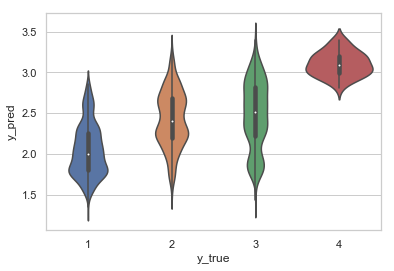

In [74]:
violin_plot_error(pipe2, X_test, y_test)

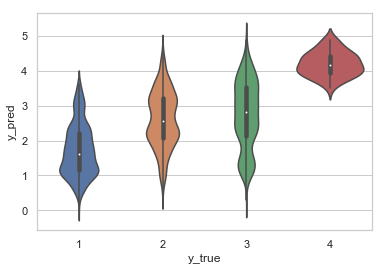

In [76]:
violin_plot_error(pipe2, X_test, y_test, rescale=True)

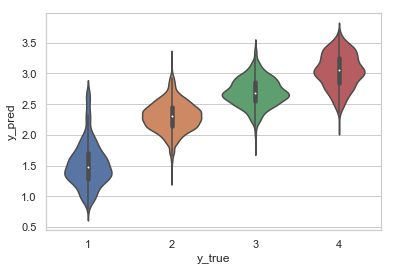

In [70]:
violin_plot_error(pipe2, X_train, y_train)

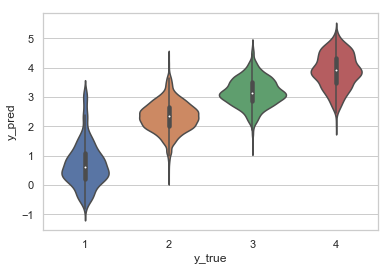

In [77]:
violin_plot_error(pipe2, X_train, y_train,rescale=True)

In [72]:
pipe2.steps

[('scaler', DataFrameMapper(default=False, df_out=False,
                  features=[(['Battery Voltage (v)', 'Temperature (deg F)',
                              'Wind Speed Average (mph)', '24 Hour Snow (in)',
                              'Total Snow Depth (in)', 'max_1_day_temp',
                              'min_1_day_temp', 'max_2_day_temp',
                              'min_2_day_temp', 'max_1_day_snow',
                              'max_2_day_snow', 'max_3_day_snow'],
                             StandardScaler(copy=True, with_mean=True,
                                            with_std=True))],
                  input_df=False, sparse=False)),
 ('regressor',
  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='ls', max_depth=3,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                       

# not so good of a prediction :/ 
my model is not able to yield predictions of low danger levels

In [34]:
import pickle

In [35]:
# save the model to disk
filename = 'avy_danger_prediction.pkl'
pickle.dump(pipe2, open(filename, 'wb'))
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.019915820418199837


In [36]:
X_test.head()

,Battery Voltage (v),Temperature (deg F),Wind Speed Minimum (mph),Wind Speed Average (mph),Wind Speed Maximum (mph),24 Hour Snow (in),Total Snow Depth (in),max_1_day_temp,min_1_day_temp,max_2_day_temp,min_2_day_temp,max_1_day_snow,max_2_day_snow,max_3_day_snow,3950ft_schmidt_haus
12578,12.72,28.36,0.022,5.600,22.36,10.16,70.17,30.79,26.41,35.37,26.41,10.23,10.23,10.23,0.02
12579,13.20,27.96,0.044,4.986,21.33,10.43,72.99,30.79,26.59,35.37,26.41,10.43,10.43,10.43,0.03
12580,12.85,26.94,0.088,4.422,15.39,10.69,70.95,30.79,26.87,33.86,26.41,10.69,10.69,10.69,0.04
12581,12.77,27.03,0.000,5.223,17.47,11.63,72.83,30.79,26.94,33.86,26.41,11.63,11.63,11.63,0.05
12582,12.74,27.21,0.175,9.730,25.78,12.04,72.29,30.79,26.94,32.58,26.41,12.04,12.04,12.04,0.04


In [39]:
df_merge.mean()

Battery Voltage (v)           12.712180
Temperature (deg F)           25.686039
Wind Speed Minimum (mph)       1.550468
Wind Speed Average (mph)       5.858092
Wind Speed Maximum (mph)      12.168595
Wind Direction (deg.)        180.236988
24 Hour Snow (in)              3.623776
Total Snow Depth (in)         91.814593
danger_above_treeline          2.560071
danger_below_treeline          2.059721
danger_near_treeline           2.373911
month                          4.464988
max_1_day_temp                30.333499
min_1_day_temp                22.116456
max_2_day_temp                32.461220
min_2_day_temp                20.594475
max_1_day_wind                21.320633
max_2_day_wind                25.705096
max_1_day_snow                12.934781
max_2_day_snow                18.338808
max_3_day_snow                22.360921
year                        2017.271577
day                           15.414616
2700ft_berne                   0.010529
3950ft_schmidt_haus            0.015020
